In [1]:
ls

Attention_imdb.ipynb  cnn_kd_twitter.ipynb      lstm_basline_Twitter.ipynb
bert_imdb.ipynb       cnn_twitter.ipynb         lstm_kd_atten_twitter.ipynb
bert_twitter.ipynb    kd_atten_lstm_imdb.ipynb  lstm_kd_twitter.ipynb
cnn_imdb.ipynb        kd_lstm_imdb.ipynb        Untitled.ipynb
cnn_kd.ipynb          lstm_baseline.ipynb


In [2]:
cd ..

/project/6006178/dongxx


In [3]:
cd twitter_baseline

/project/6006178/dongxx/twitter_baseline


In [4]:
from bert_train import validate, prepare_dateset,generate_batch,epoch_time
import torch
import torch.nn as nn
import numpy as np
from models import BERTGRUSentiment
from torch.utils.data import DataLoader
from torchtext.vocab import GloVe,Vocab,Vectors
from tqdm import tqdm
from utils import Twitter_indexing, pad_sequenc,pad_sequencing
from models import CNN_Baseline,LSTMBaseline
import torchtext.vocab
import csv
import pandas as pd
import argparse
import logging
import os
import pickle
import sys
import config
config.seed_torch()
from collections import Counter
import time
import copy

In [5]:
from transformers import BertTokenizer, BertModel,BertForSequenceClassification

In [6]:
device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')

In [7]:
model = BertForSequenceClassification.from_pretrained(
        'bert-base-uncased',
        num_labels=2,
        output_attentions=False,
        output_hidden_states=False)

Some weights of the model checkpoint at bert-base-uncased were not used when initializing BertForSequenceClassification: ['cls.seq_relationship.bias', 'cls.predictions.decoder.weight', 'cls.predictions.bias', 'cls.predictions.transform.LayerNorm.weight', 'cls.predictions.transform.dense.weight', 'cls.predictions.transform.LayerNorm.bias', 'cls.predictions.transform.dense.bias', 'cls.seq_relationship.weight']
- This IS expected if you are initializing BertForSequenceClassification from the checkpoint of a model trained on another task or with another architecture (e.g. initializing a BertForSequenceClassification model from a BertForPreTraining model).
- This IS NOT expected if you are initializing BertForSequenceClassification from the checkpoint of a model that you expect to be exactly identical (initializing a BertForSequenceClassification model from a BertForSequenceClassification model).
Some weights of BertForSequenceClassification were not initialized from the model checkpoint at

In [9]:
test = '/home/dongxx/projects/def-parimala/dongxx/data140/test.csv'
valid = '/home/dongxx/projects/def-parimala/dongxx/data140/valid.csv'
train ='/home/dongxx/projects/def-parimala/dongxx/data140/train.csv'

In [10]:
train_dataset, validation_dataset,test_dataset,labellist  = prepare_dateset(train, valid,test)
testing = DataLoader(test_dataset, collate_fn= generate_batch, batch_size=128, shuffle=False)

Start loading training data
Finish loading training data
Start loading validation data
Finish loading validation data
Start loading testing data
Finish loading testing data
prepare training and test sets


In [11]:
model.to(device)
model.load_state_dict(torch.load(config.BERT_Tiwtter_PATH))
criterion = nn.CrossEntropyLoss()
criterion.to(device)
start_time = time.time()
test_loss, test_acc,flat_list = validate(testing, model, criterion, device)
end_time = time.time()
epoch_mins, epoch_secs = epoch_time(start_time, end_time)
print(f' | Epoch Time: {epoch_mins}m {epoch_secs}s')

Truncation was not explicitly activated but `max_length` is provided a specific value, please use `truncation=True` to explicitly truncate examples to max length. Defaulting to 'longest_first' truncation strategy. If you encode pairs of sequences (GLUE-style) with the tokenizer you can select this strategy more precisely by providing a specific strategy to `truncation`.


 | Epoch Time: 5m 45s


In [12]:
print(f'Test Loss: {test_loss:.3f} | Test Acc: {test_acc * 100:.2f}%')



Test Loss: 0.299 | Test Acc: 87.66%


In [13]:
pred_list =[item.cpu().numpy() for sublist in flat_list for item in sublist]

In [14]:
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import LabelEncoder
from sklearn.metrics import confusion_matrix, classification_report, accuracy_score
import matplotlib.pyplot as plt
import itertools

In [15]:
def plot_confusion_matrix(cm, classes,
                          title='Confusion matrix',
                          cmap=plt.cm.Blues):
    """
    This function prints and plots the confusion matrix.
    Normalization can be applied by setting `normalize=True`.
    """

    cm = cm.astype('float') / cm.sum(axis=1)[:, np.newaxis]

    plt.imshow(cm, interpolation='nearest', cmap=cmap)
    plt.title(title, fontsize=30)
    plt.colorbar()
    tick_marks = np.arange(len(classes))
    plt.xticks(tick_marks, classes, rotation=90, fontsize=22)
    plt.yticks(tick_marks, classes, fontsize=22)

    fmt = '.2f'
    thresh = cm.max() / 2.
    for i, j in itertools.product(range(cm.shape[0]), range(cm.shape[1])):
        plt.text(j, i, format(cm[i, j], fmt),
                 horizontalalignment="center",
                 color="white" if cm[i, j] > thresh else "black")

    plt.ylabel('True label', fontsize=25)
    plt.xlabel('Predicted label', fontsize=25)

In [16]:
pred_list =[item.cpu().numpy() for sublist in flat_list for item in sublist]

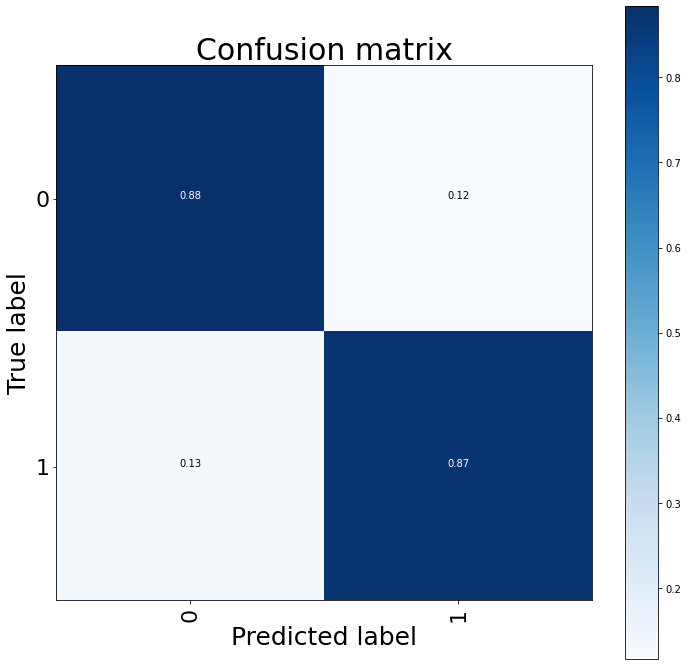

In [17]:
cnf_matrix = confusion_matrix(labellist, pred_list)
plt.figure(figsize=(12,12))
plot_confusion_matrix(cnf_matrix, classes=[0,1], title="Confusion matrix")
plt.show()

In [18]:
print(classification_report(labellist, pred_list,digits=4))

              precision    recall  f1-score   support

           0     0.8717    0.8833    0.8775     80000
           1     0.8817    0.8700    0.8758     80000

    accuracy                         0.8766    160000
   macro avg     0.8767    0.8766    0.8766    160000
weighted avg     0.8767    0.8766    0.8766    160000

